# Neutrophil-to-lymphocyte ratio can be a strong preditor for clinical

outcomes in rectal cancer?

R & Python Study Group (KIRAMS)

In [ ]:
# 프로젝트에는 필요하나 manuscript에 적합하지 않한 출력을 하는 코드들의 출력을 조정하기 위한 환경변수
manusctipt_mode<-"Y" # "Y"이면 manuscript에 적합한 출력을 하고, "N"이면 manuscript에 적합하지 않은 출력을 함

In [ ]:
# 라이브러리들은 한 곳에 모아두어 총 로딩시간을 줄이고자 함
library(readxl)
library(data.table)
library(moonBook)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: 'survminer'

The following object is masked from 'package:survival':

    myeloma

Loading required package: carData


Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'rms'

The following objects are masked from 'package:car':

    Predict, vif

Loading required package: lattice


Attaching package: 'lattice'

The following object is masked from 'package:moonBook':

    densityplot


Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster

Loading required package: prodlim


Attaching package: 'pec'

The following object is masked from 'package:caret':

    R2


Attaching package: 'purrr'

The following object is masked from 'package:caret':

    lift

The following object is masked from 'package:car':

    some

The following object is masked from 'package:data.table':

    transpose


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

Loading required package: tinylabels

In [ ]:
################################################################################
# 파일경로 및 patten을 이용해서 data.table로 읽어오기 
################################################################################

load_raw_data <- function(folder_path, pattern) {

  excel_file_name <- list.files(folder_path, pattern = pattern)
  if(length(excel_file_name) == 0) {
    stop("No files starting with 'NLR' found in the specified folder.")
  }
  data <- as.data.table(read_excel(file.path(folder_path, excel_file_name[1])))

    return(data)
}


folder_path <- "C:/R/Projects/R-4.4.0-Rectal_Cancer_NLR/data/raw_data/"
pattern <- "NLR.*"
raw_data <- raw_data_initial <- load_raw_data(folder_path, pattern)

In [ ]:
################################################################################
# 데이터 전처리 
################################################################################
#    # 임상시험번호로 추정되는 MRN과 날짜를 포함하는 37열부터 41열까지는 제외
#    # NA>35 이상으로 전체 데이터 920임에 비해 상대적으로 많은 열들은 삭제
#    # 특정변수가 "Unknown"이면 raw_data 해당 행을 삭제
#    # 특정변수 중 빈도가 1일 정도로 낮은 값들을 삭제 (다변량 cox는 NA가 없어야 함)
#    # mistyping 교정
#    # 범주형변수를 임상적의미와 빈도를 고려해 재설정
################################################################################

# 임상시험번호로 추정되는 MRN과 날짜를 포함하는 37열부터 41열까지는 제외
raw_data <- raw_data[, -c(1, 37:41), with = FALSE]
raw_data[raw_data == "NA"] <- NA

# NA>35 이상으로 전체 데이터 927에 비해 상대적으로 많은 열들은 삭제
raw_data <- select(raw_data, -c(CCTx, ASA, Induct, RT_dose, Recur_site, Surgery,PNI, LV_PNI, Viable, LVI, Adj_KIND, cStage23, CTx_regimen))
raw_data <- raw_data[complete.cases(raw_data), ]

# 특정변수가 "Unknown"이면 raw_data 해당 행을 삭제
raw_data <- raw_data[cT != "Unknown"]
raw_data <- raw_data[cN != "Unknown"]
raw_data <- raw_data[cStage != "Unknown"]

# 특정변수 중 빈도가 1일 정도로 낮은 값들을 삭제
raw_data <- raw_data[Histology != "MD,MUC"]
raw_data <- raw_data[Histology != "MUC"]
raw_data <- raw_data[Histology != "SRC"]
raw_data <- raw_data[Histology != "SRC,PD"]
raw_data <- raw_data[Ptve_LN != "-2"]

# mistyping 교정
# raw_data[Surgery == "aPR", Surgery := "APR"]
raw_data[CRM == "negative", CRM := "Negative"]

# 범주형변수를 임상적의미와 빈도를 고려해 재설정
raw_data[pT == "is", pT := "0"]
raw_data[pT == "4a", pT := "4"]
raw_data[pT == "4b", pT := "4"]
raw_data[pT == "4B", pT := "4"]
raw_data[pN == "1c", pN := "1"]

In [ ]:
################################################################################
# 엑셀을 읽어오면서 숫자 및 문자가 부적절하게 된 것을 수정하는 함수
################################################################################
#   # factor, numeric으로 변환
#   # 독립변수 factor 변환
#   # 독립변수 numeric 변환
################################################################################

type_casting_data <- function(data) {

  #종속변수 factor 변환
  data$RECUR <- factor(data$RECUR, levels = c(0, 1), labels = c("No", "Yes"))
  data$DEAD <- factor(data$DEAD, levels = c(0, 1), labels = c("No", "Yes"))
  
  #독립변수 factor 변환
  data$Male <- factor(data$Male, levels = c(0, 1), labels = c("Female", "Male"))
  data$Induction <- factor(data$Induction, levels = c(0, 1), labels = c("No", "Yes"))
  data$MIS <- factor(data$MIS, levels = c(0, 1), labels = c("No", "Yes"))
  data$SSS <- factor(data$SSS, levels = c(0, 1), labels = c("No", "Yes"))
  data$ypStage <- factor(data$ypStage, levels = c(0, 1, 2, 3), labels = c("0", "1", "2", "3"))
  data$RES_G <- factor(data$RES_G, levels = c(1, 2, 3), labels = c("1", "2", "3"))
  
  # 독립변수 numeric 변환
  data$RTOP_W <- as.numeric(data$RTOP_W)
  data$total.LN <- as.numeric(data$total.LN)
  data$Ptve_LN <- as.numeric(data$Ptve_LN)
  data$CEA <- as.numeric(data$CEA)
  data$preAlb <- as.numeric(data$preAlb)
  data$preWBC <- as.numeric(data$preWBC)
  data$preNEU <- as.numeric(data$preNEU)
  data$preLYM <- as.numeric(data$preLYM)
  data$prePLT <- as.numeric(data$prePLT)
  data$preNLR <- round(as.numeric(data$preNLR), 2)
  data$prePLR <- round(as.numeric(data$prePLR), 2)
  data$preAlb <- as.numeric(data$preAlb)
  data$postWBC <- as.numeric(data$postWBC)
  data$postNEU <- as.numeric(data$postNEU)
  data$postLYM <- as.numeric(data$postLYM)
  data$postPLT <- as.numeric(data$postPLT)
  data$postNLR <- round(as.numeric(data$postNLR), 2)
  data$postPLR <- round(as.numeric(data$postPLR), 2)
  
  return(data)
}


type_casted_data<-type_casting_data(raw_data)

In [ ]:
################################################################################
# raw_data를 정리한 table을 만들기
################################################################################
#   # RECUR 여부에 따른 변수들의 기술적 분포표
#   # DEAD 여부에 따른 기술적 분포표
#   # 독립변수 numeric 변환
################################################################################

# RECUR 여부에 따른 변수들의 기술적 분포표
type_casted_data_table_RECUR<-mytable(RECUR ~ .-POS-DEAD, data = type_casted_data)
# DEAD 여부에 따른 기술적 분포표
type_casted_data_table_DEAD<-mytable(DEAD ~ .-PDFS-RECUR, data = type_casted_data)

#표를 데이터프레임을 전환
tb1<-as.data.frame(type_casted_data_table_RECUR$res)
tb2<-as.data.frame(type_casted_data_table_DEAD$res)

# 원하는 부분만 선택한 후
tb3<-tb1 %>% select(1:4)
tb4<-tb2 %>% select(2:4)

# 두 표를 하나로 합치기
table<-cbind(tb3,tb4)

# count_row를 생성하여 RECUR 및 DEAD의 NO YES에 따른 빈도 표시 추가
header_row <- c(
  "",
  paste("(N=", type_casted_data_table_RECUR$count[1], ")", sep=""),
  paste("(N=", type_casted_data_table_RECUR$count[2], ")", sep=""),
  "", 
  paste("(N=", type_casted_data_table_DEAD$count[1], ")", sep=""),
  paste("(N=", type_casted_data_table_DEAD$count[2], ")", sep=""),
  ""
)
type_casted_data_table<-rbind(header_row,table)

rm(tb1, tb2, tb3, tb4, table, header_row,type_casted_data_table_RECUR,type_casted_data_table_DEAD)



if (manusctipt_mode!="Y") {
  type_casted_data_table
}

In [ ]:
################################################################################
# 연속형변수들의 cut_off value에 따른 이분화
################################################################################
#   # cut_off value를 반환하는 함수
#   # 숫자인 것을 이분화하는 과정에서 컬럼명을 삭제하기 위해 사용하는 함수
#   # 변수 하나를 cut_off value로 2분화된 범주형변수로 변한하는 함수
#   # 모든 연속형변수들을 한꺼번에 cut_off value로 2분화된 범주형변수로 변한하는 함수
################################################################################

# cut_off value를 반환하는 함수
run_maxstat_test <- function(dt, column_name) {
  mstat <- maxstat.test(Surv(PDFS, RECUR) ~ dt[[column_name]], data = dt,
                        smethod = "LogRank", pmethod = "condMC", B = 999)
  return(mstat$estimate)
}

# 숫자인 것을 이분화하는 과정에서 컬럼명을 삭제하기 위해 사용하는 함수
remove_continuous_columns <- function(dt) {
  continuous_columns <- grep("continuous", names(dt), value = TRUE)
  dt[, (continuous_columns) := NULL]
  return(dt)
}

# 변수 하나를 cut_off value로 2분화된 범주형변수로 변한하는 함수
transform_column <- function(dt, column_name, cut_off_value) {

  # 기존 컬럼명을 컬럼명_continuous로 변경
  new_column_name <- paste(column_name, "_continuous", sep = "")
  setnames(dt, old = column_name, new = new_column_name)
  # 새로운 컬럼을 파생시키고 값을 설정
  dt[, (column_name) := ifelse(is.na(.SD), NA, ifelse(.SD > cut_off_value, 1, 0)), .SDcols = new_column_name]
  dt[, (column_name) := factor(dt[[column_name]], levels = c(0, 1), labels = c(paste(">", cut_off_value), paste("≤", cut_off_value)))]
  dt<-remove_continuous_columns(dt)
  
  return(dt)
}

# 데이터테이블을 인자로 받아서 연속형변수에 한해 cut_off value로 2분화된 범주형변수로 변한하는 함수
dichotomization_continuous_variables <- function(dt) {
  numeric_columns <- names(dt)[sapply(dt, is.numeric)]
  exclude_columns <- c("PDFS", "POS")  # 제외할 컬럼명 리스트
  for(col in numeric_columns) {
    if(col %in% exclude_columns) {
      next  # PDFS 또는 POS인 경우 다음 순회로 넘어감
    }
    cut_off_value <- run_maxstat_test(dt, col)
    dichotomized_data<-transform_column(dt, col, cut_off_value)
  }
  return(dt)
}


dichotomized_data<-dichotomization_continuous_variables(type_casted_data)

In [ ]:
################################################################################
# 범주형변수 값들의 분포와 빈도, 필요 시 합치기
################################################################################
#   # ggpsurvplot 함수에서는 status에 해당하는 변수를 numeric으로 type casting 하니 오류가 없어져서 불가피하게 numeric으로 진행
#   # 데이터테이블을 전달하여 ggpsurvplot를 범주형변수들에 대해 그리는 함수 만들기 실패!. 따라서 범주형변수마다 그래프 확인함
#   # 일부 범주형변수들에서는 그 값들을 합쳐서 진행함 
#   # 모든 연속형변수들을 한꺼번에 cut_off value로 2분화된 범주형변수로 변한하는 함수
################################################################################

# ggpsurvplot 함수에서는 status에 해당하는 변수가 factor가 지원되지 안으므로 numeric으로 type casting 하여 진행
dichotomized_data$RECUR<-as.numeric(dichotomized_data$RECUR)

# 데이터테이블을 전달하여 ggpsurvplot를 범주형변수들에 대해 그리는 함수 만들기 실패!. 따라서 범주형변수마다 그래프 확인함
plot_LOC<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ LOC, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
    )
if (manusctipt_mode!="Y") {
  plot_LOC
}

plot_cT<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ cT, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_cT
}

dichotomized_data$cT <- ifelse(dichotomized_data$cT == "2", "2", "3/4")
plot_cT<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ cT, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_cT
}

plot_cN<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ cN, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_cN
}
# 일부 범주형변수들에서는 그 값들을 합쳐서 진행함 
dichotomized_data$cN <- ifelse(dichotomized_data$cN == "2", "2", "0/1")
plot_cN<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ cN, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_cN
}

plot_APPROACH<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ APPROACH, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_APPROACH
}

dichotomized_data$APPROACH <- ifelse(dichotomized_data$APPROACH == "Open", "Open", "Laparoscopic/Robot")
plot_APPROACH<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ APPROACH, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_APPROACH
}

plot_Histology<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ Histology, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_Histology
}

dichotomized_data$Histology <- ifelse(dichotomized_data$Histology == "WD", "WD", "MD/PD")
plot_Histology<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ Histology, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_Histology
}

plot_pT<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ pT, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_pT
}

dichotomized_data$pT <- ifelse((dichotomized_data$pT == "3")|(dichotomized_data$pT == "4"), "3/4", "0/1/2")
plot_pT<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ pT, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_pT
}

plot_pN<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ pN, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_pN
}

plot_ypStage<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ ypStage, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_ypStage
}


plot_RES_G<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ RES_G, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_RES_G
}

dichotomized_data$RES_G <- ifelse(dichotomized_data$RES_G == "3", "3", "1/2")
plot_RES_G<-ggsurvplot(
    survfit(Surv(PDFS, RECUR) ~ RES_G, data = dichotomized_data),
    pval = TRUE,
    risk.table = TRUE
  )
if (manusctipt_mode!="Y") {
  plot_RES_G
}

## Background

## Methods

### Patient cohort

We retrospectively reviewed **927** RC patients who underwent R0 and **R1** surgical resection between **** and **-** at the **MD Anderson Cancer Center**. **(우선 NA 값이 40 case 이상 포함된 항목들은 항목 자체를 분석에서 제외하였고, 다음으로는 NA가 하나라도 포함된 case를 분석에서 제외하였다. )** Magnetic resonance imaging was used to evaluate the clinical stage of the tumour preoperatively. The final diagnosis of the patients was confirmed by routine pathology. The exclusion criteria were as follows: recurrent or metastatic RC confirmed preoperatively or at surgery, emergency cases, unavailable clinicopathological data, more than 1 primary cancer, receiving anticancer treatments preoperatively, resections with macro- or microscopically positive pathological margins and with active infection or the use systemic corticosteroids. The TNM classification of malignant tumours, 8th edition, edited by the Union for International Cancer Control (UICC) was used to determine the TNM stage. Patients with T1 RCs and no signs of lymph node metastasis on endorectal ultrasound or MRI underwent local excision through transanal endoscopic microsurgery (TEM), or laparoscopic or open surgery was performed. Informed consent was obtained from each patient, and the present study was approved by the Ethics Committee of the **KIRAMS.**

### Definitions

Peripheral blood was obtained 1 week prior to surgery. The NLR was determined by dividing the absolute neutrophil count by the absolute lymphocyte count; the PLR was determined by dividing the absolute platelet count by the absolute lymphocyte count; and the LMR was determined by dividing the absolute lymphocyte count by the absolute monocyte count. The PNI was calculated by the following formula: serum albumin (g/L) + 5 × total lymphocyte count × 109/L. \[19\] Postoperative complications were defined as any in-hospital or 30-day postoperative complication and graded according to the Clavien- Dindo classification \[20\].

### Follow-up and study endpoints

Patients were followed-up periodically after surgery. Re-examination was performed at 3-month intervals for the first 2 years postoperatively, every 6months for the next 3 years and every year thereafter. Physical examinations and blood tests, including serum carcinoembryonic antigen (CEA) levels, were performed at each follow-up. A chest X-ray and abdominopelvic computed tomography scan were performed every 6 months, and colonoscopy was performed annually or when there was a suspicion of recurrence. In addition, rigid rectoscopy and endorectal ultrasound were conducted at every visit except for the colonoscopy visit of the TEM patients. The primary endpoints were cancer recurrence or death. The secondary endpoint was the occurrence of postoperative complications. Overall survival (OS) was calculated as the date of diagnosis to the date of death from any cause. Disease-free survival (DFS) was defined as the time interval from cancer diagnosis until tumour recurrence or death from any cause.

### Statistical analysis

The data are presented as the mean ± standard deviation. Categorical variables were analysed with Pearson’s Chisquare test or Fisher’s exact test as appropriate. The cutoff values for NLR, PLR, LMR, and PNI were determined using **maxstat package test function**. Kaplan–Meier analysis and the log rank test were used to compare the survival curves of the 2 groups. Risk factors for poor survival were detected by univariate and multivariate analyses using the Cox proportional hazards model. Variables with a P value of \< 0.05 in the univariate analysis were further evaluated in the multivariate analysis to assess the independent predictors for **DFS.** **Before performing multivariate analysis, multicollinearity was assessed, and a Variance Inflation Factor (VIF) of less than 10 was deemed acceptable.** Statistical analyses were performed using **R version 4.4.0 (2024-04-24 ucrt).** A statistically significant difference was defined as a P value of \< 0.05.

## Results

### Baseline patient characteristics and inflammatory-related parameters

A total of **806** RC patients were enrolled in this study. The characteristics of the patients are shown in **Table 1.** Our study group comprised 90 (58.4%) male and 64 (41.6%) female patients, with a mean age of 63.7 years (range 32–90 years). A total of 63 (40.9%) patients had 1 or more comorbidities. TEM was conducted in 47 patients, while laparoscopic (n = 53) or open surgery (n = 54) was performed in 107 patients. No mortality occurred 30 days after the operation. A total of 26 complications (grade I-IVa) occurred in 22 (14.3%) patients postoperatively, including 22 grade I-II and 4 grade III-IVa complications. With a median followup interval of 42.4 months (range 12–89 months), the 3- year OS and DFS rates of all patients were 90.9 and 87.7%, respectively. Three patients died from a cause other than rectal cancer. The distributions of preoperative inflammatory-related parameters are shown in Table 2. The optimal cut-off values for preoperative NLR, PLR, LMR and PNI that best predicted OS were calculated to be 2.8 (area under the curve (AUC): 0.71; sensitivity: 53.0%; specificity: 84.0%), 140.0 (AUC: 0.64; sensitivity: 80.0%; specificity: 58.0%), 3.9 (AUC: 0.68; sensitivity: 73.0%; specificity: 65.0%), and 47.1 (AUC: 0.75; sensitivity: 60.0%; specificity: 83.0%), respectively (Fig. 1a-d). Then, the patients were dichotomized into high or low NLR/PLR/LMR/PNI groups with these cut-off values. The numbers and features of patients in each group are listed in Table 1.

In [ ]:
kable(type_casted_data_table, caption = "Table 1 Descriptive Statistics by RECUR and DEAD")

cox 단변량분석에서 유의한 결과를 보였던 변수들은 아래와 같습니다.

In [ ]:
################################################################################
# 모든 변수들로 univariate cox 시행하고 p-value 기준치 이상을 선별
################################################################################
#   # mycph 
#   # p-value < 0.05
#   # mycph 결과를 변수명 리스트로 만들기
################################################################################

# mycp
univariate_cox_DFS <- mycph(Surv(PDFS, RECUR)~.-PDFS-RECUR-POS-DEAD, data = dichotomized_data)


 mycph : perform coxph of individual expecting variables

 Call: Surv(PDFS, RECUR) ~ . - PDFS - RECUR - POS - DEAD, data= dichotomized_data 

 [1] "SSS"      "DRM"      "R1"       "pT"       "pN"       "ypStage" 
 [7] "RES_G"    "AGE"      "total.LN" "Ptve_LN"  "CEA"      "preAlb"  
[13] "preNEU"   "preLYM"   "postNEU"  "postPLT"  "postNLR"  "postPLR" 

**공선성분석에서는 pN과 RES_G를 제외하였더니 만족되었다.**

In [ ]:
################################################################################
# 선형회귀부석모델을 만든 후 VIF > 10 제거 
################################################################################
#     # 아래의 과정을 반복하여 VIF 10 이하로 만들어 줌
#     # 이 데이터에서는 pN과 RES_G를 제거함
################################################################################
model = lm(RECUR ~ SSS+DRM+R1+pT+ypStage+AGE+total.LN+Ptve_LN+CEA+preAlb+preNEU+preLYM+postNEU+postPLT+postNLR+postPLR,data = dichotomized_data)
colinearity_result<-car::vif(model)
colinearity_result

             GVIF Df GVIF^(1/(2*Df))
SSS      1.068631  1        1.033746
DRM      1.445017  1        1.202088
R1       1.452308  1        1.205118
pT       3.730146  1        1.931359
ypStage  4.695248  3        1.294026
AGE      1.050999  1        1.025183
total.LN 1.035339  1        1.017516
Ptve_LN  1.415612  1        1.189795
CEA      1.079665  1        1.039069
preAlb   1.068323  1        1.033597
preNEU   1.113300  1        1.055130
preLYM   1.073133  1        1.035921
postNEU  1.507040  1        1.227616
postPLT  1.197952  1        1.094510
postNLR  1.859504  1        1.363636
postPLR  1.545548  1        1.243201

**cox 다변량분석결과**

In [ ]:
# 단변량 Cox 비례위험 회귀 테이블 생성
uni_tbl <- tbl_uvregression(
  data = dichotomized_data %>%
    select(SSS, DRM, R1, pT, ypStage, AGE, total.LN, Ptve_LN, CEA, preAlb, preNEU, preLYM, postNEU, postPLT, postNLR, postPLR,PDFS, RECUR),
  method = coxph,
  y = Surv(PDFS, RECUR),
  exponentiate = TRUE,
  hide_n = TRUE
) %>%
  modify_footnote(everything() ~ NA)

# 다변량 Cox 비례위험 회귀 테이블 생성
multivariate_cox_model_DFS <- coxph(Surv(PDFS, RECUR) ~ SSS+DRM+R1+pT+ypStage+AGE+total.LN+Ptve_LN+CEA+preAlb+preNEU+preLYM+postNEU+postPLT+postNLR+postPLR,data = dichotomized_data)
mult_tbl <- tbl_regression(
  x = multivariate_cox_model_DFS,
  exponentiate = T,
  pvalue_fun = ~ style_pvalue(., digits = 3),
  estimate_fun = ~style_ratio(., digits = 2)
) |> 
  bold_p() |> 
  # modify_column_merge(pattern = "{estimate} ({conf.low}-{conf.high})",
  #                     rows = !is.na(estimate)) |> 
  add_significance_stars(hide_ci = T, hide_se = T) |> 
  modify_header(
    label = "**Variable**",
    estimate = "**OR (95% CI)**",
    p.value = "**P value**"
  ) |> 
  modify_footnote(everything() ~ NA)

# 테이블 합치기
tbl_merge(
  list(uni_tbl, mult_tbl),
  tab_spanner = 
    c("**Univariable**", "**Multivariable**")
) |> 
  as_flex_table()

Univariable Multivariable Characteristic HR 1 95% CI 1 p-value OR (95% CI) 1 P value SSS No — — — Yes 0.60 0.41, 0.89 0.012 0.74 0.150 DRM Negative — — — Positive 4.64 1.14, 18.8 0.032 6.98* 0.048 R1 0 — — — 1 2.53 1.03, 6.19 0.043 0.96 0.942 pT 0/1/2 — — — 3/4 3.74 2.46, 5.68 <0.001 1.95 0.051 ypStage 0 — — — 1 2.31 0.77, 6.96 0.14 2.01 0.218 2 5.63 1.98, 16.0 0.001 2.33 0.182 3 9.90 3.61, 27.2 <0.001 4.08* 0.018 AGE > 42 — — — ≤ 42 0.48 0.29, 0.79 0.004 0.52* 0.012 total.LN > 10 — — — ≤ 10 0.62 0.41, 0.94 0.024 0.48*** <0.001 Ptve_LN > 2 — — — ≤ 2 4.40 2.93, 6.60 <0.001 2.37*** <0.001 CEA > 4.2 — — — ≤ 4.2 2.03 1.40, 2.94 <0.001 1.34 0.142 preAlb > 4 — — — ≤ 4 0.64 0.44, 0.94 0.021 0.75 0.164 preNEU > 3.7 — — — ≤ 3.7 1.68 1.07, 2.66 0.026 1.43 0.145 preLYM > 1.17 — — — ≤ 1.17 2.04 1.03, 4.04 0.040 2.71** 0.007 postNEU > 4.12 — — — ≤ 4.12 1.50 1.02, 2.19 0.039 1.07 0.788 postPLT > 197 — — — ≤ 197 1.99 1.24, 3.19 0.004 1.41 0.188 postNLR > 5.93 — — — ≤ 5.93 1.58 1.08, 2.30 0.018 1.14 0.634 postPLR > 307.81 — — — ≤ 307.81 1.61 1.11, 2.34 0.011 1.60* 0.048 1 HR = Hazard Ratio, CI = Confidence Interval

후진제거법을 적용했을 때 유의한 변수들은 아래와 같았다.

In [ ]:
stepwise_cox_modelfind<-step(multivariate_cox_model_DFS, direction = 'backward') # 후진제거법 적용 

Start:  AIC=1354.42
Surv(PDFS, RECUR) ~ SSS + DRM + R1 + pT + ypStage + AGE + total.LN + 
    Ptve_LN + CEA + preAlb + preNEU + preLYM + postNEU + postPLT + 
    postNLR + postPLR

           Df    AIC
- R1        1 1352.4
- postNEU   1 1352.5
- postNLR   1 1352.7
- postPLT   1 1354.2
- preAlb    1 1354.3
<none>        1354.4
- SSS       1 1354.4
- CEA       1 1354.5
- preNEU    1 1354.7
- DRM       1 1355.7
- postPLR   1 1356.3
- pT        1 1356.7
- AGE       1 1358.0
- ypStage   3 1358.1
- preLYM    1 1361.7
- total.LN  1 1362.3
- Ptve_LN   1 1363.5

Step:  AIC=1352.42
Surv(PDFS, RECUR) ~ SSS + DRM + pT + ypStage + AGE + total.LN + 
    Ptve_LN + CEA + preAlb + preNEU + preLYM + postNEU + postPLT + 
    postNLR + postPLR

           Df    AIC
- postNEU   1 1350.5
- postNLR   1 1350.7
- postPLT   1 1352.2
- preAlb    1 1352.3
<none>        1352.4
- SSS       1 1352.4
- CEA       1 1352.5
- preNEU    1 1352.7
- postPLR   1 1354.3
- DRM       1 1354.4
- pT        1 1354.7
- AGE       1

In [ ]:
finalized_model<-coxph(Surv(PDFS, RECUR) ~ SSS + DRM + pT + ypStage + AGE + total.LN + Ptve_LN + CEA + preAlb + preNEU + preLYM + postPLR, data=dichotomized_data)
summary(finalized_model)

Call:
coxph(formula = Surv(PDFS, RECUR) ~ SSS + DRM + pT + ypStage + 
    AGE + total.LN + Ptve_LN + CEA + preAlb + preNEU + preLYM + 
    postPLR, data = dichotomized_data)

  n= 806, number of events= 114 

                    coef exp(coef) se(coef)      z Pr(>|z|)    
SSSYes           -0.3208    0.7256   0.2074 -1.546 0.122048    
DRMPositive       1.9930    7.3372   0.7507  2.655 0.007936 ** 
pT3/4             0.6932    2.0001   0.3414  2.030 0.042328 *  
ypStage1          0.7044    2.0226   0.5673  1.242 0.214340    
ypStage2          0.8455    2.3292   0.6324  1.337 0.181241    
ypStage3          1.3893    4.0121   0.5938  2.340 0.019291 *  
AGE≤ 42         -0.6372    0.5288   0.2588 -2.462 0.013809 *  
total.LN≤ 10    -0.7492    0.4727   0.2248 -3.333 0.000860 ***
Ptve_LN≤ 2       0.8706    2.3884   0.2541  3.426 0.000612 ***
CEA≤ 4.2         0.3118    1.3659   0.1979  1.576 0.115090    
preAlb≤ 4       -0.3032    0.7384   0.2021 -1.500 0.133486    
preNEU≤ 3.7      0.4421    1

**HR plot**

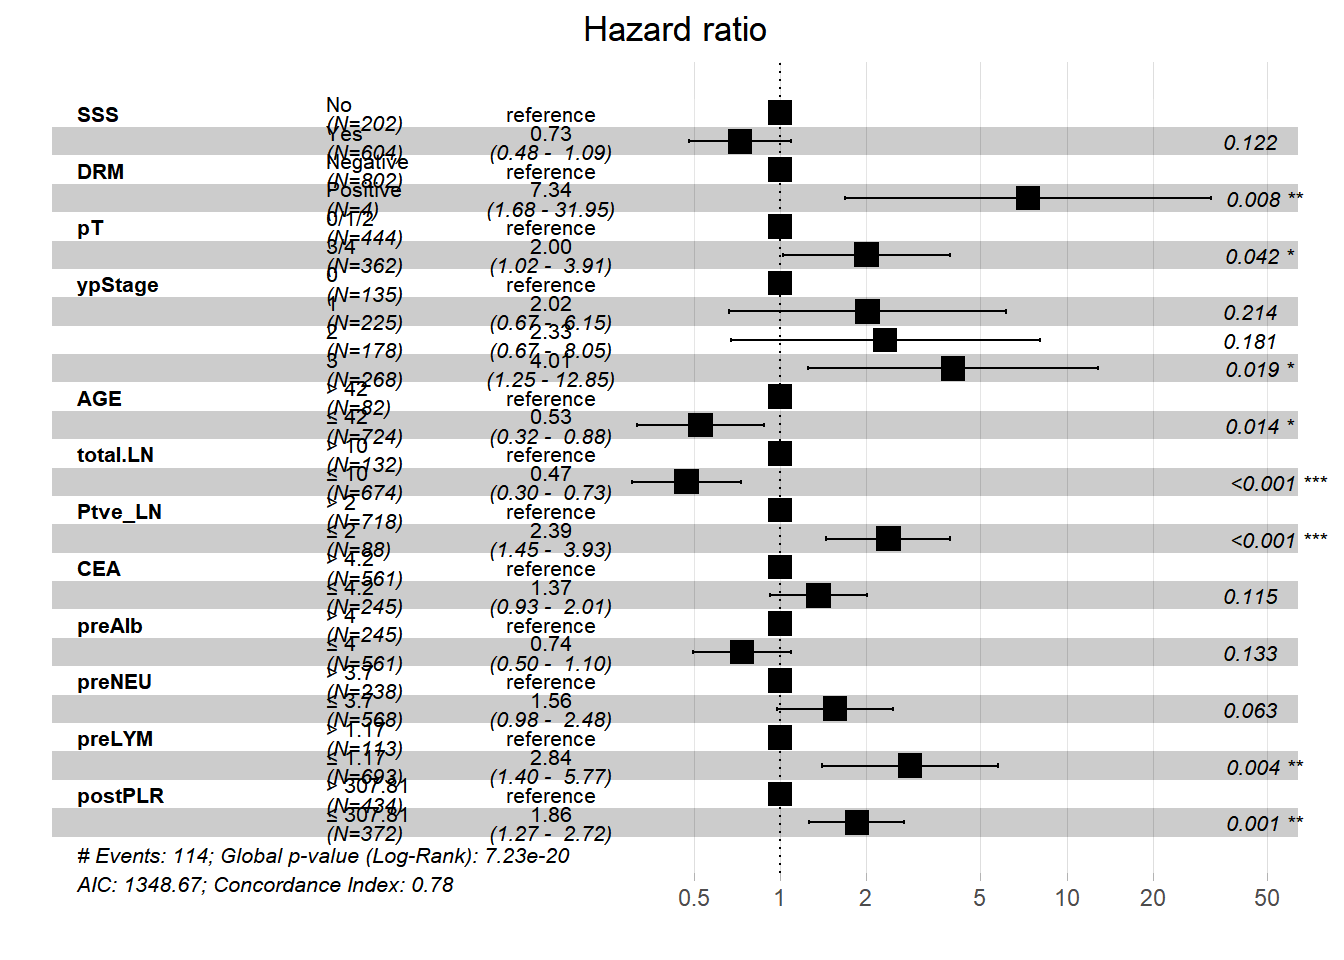

In [ ]:
ggforest(finalized_model, data=dichotomized_data)

In [ ]:
set.seed(42)

k <- 5
folds <- createFolds(dichotomized_data$RECUR, k = k, list = TRUE, returnTrain = TRUE)

# 각 폴드의 concordance index 저장
c_indices <- c()

for (i in 1:k) {
  train_indices <- folds[[i]]
  test_indices <- setdiff(seq_len(nrow(dichotomized_data)), train_indices)
  
  train_data <- dichotomized_data[train_indices, ]
  test_data <- dichotomized_data[test_indices, ]
  
  # CoxPH 모델 적합
  cox_model <- coxph(Surv(PDFS, RECUR) ~ SSS + DRM + pT + ypStage + AGE + total.LN + Ptve_LN + CEA + preAlb + preNEU + preLYM + postPLR, data = train_data)
  
  
  # 테스트 데이터에서 예측 위험도 계산
  test_data$predicted_risk <- predict(cox_model, newdata = test_data, type = "risk")
  
 # concordance index 계산
  concordance_result <- concordance(Surv(test_data$PDFS, test_data$RECUR) ~ test_data$predicted_risk)
  c_index <- concordance_result$concordance
  
  c_indices <- c(c_indices, c_index)
}

Warning in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
Loglik converged before variable 2 ; coefficient may be infinite.

각 폴드의 concordance indices:  0.1869236 0.1902909 0.2984035 0.2707854 0.3754522 

평균 concordance index:  0.2643711 

concordance index의 표준 편차:  0.07909545 

## Discussion